# Part 3: Moving Average

For Part 3 of the Time Series Analysis, this notebook will look at Moving Average Regression. Unlike normal regression, there is a window parameter where chunks of data are regressed upon. As a result, there are multiple regression lines instead of one. This allows for tighter mapping compared to regular regression. However, this comes at the cost of limited forcasting ability, usually one data point out.  
The reference source for this advanced analysis can be found [here](https://towardsdatascience.com/machine-learning-techniques-applied-to-stock-price-prediction-6c1994da8001)

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np  
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression

#I tooke the appl stock data and moved it into a more convient file location
pathToData = "StockData\AppleStock.txt"

#Check if there is a valid file in directory
if(os.path.isfile(pathToData)):
    print("Path Found")
    data = pd.read_csv(pathToData, sep=",")
else:
    print("Path Not Found")

Path Found


In [2]:
datesData = data["Date"].tolist()
openPriceData = data["Open"].tolist() 
closePricedata = data["Close"].tolist()

print(len(datesData))
frontSlice = 8364 - 3650
endSlice = 8364
trimDatesData = datesData[frontSlice:endSlice]
trimOpenPriceData = openPriceData[frontSlice:endSlice]
trimClosePriceData = closePricedata[frontSlice:endSlice]

8364


In [3]:
#The Dates are in the in a string format. For a linear regression analysis,
#the dates need to placed into numeric values. We can correspond the dates to
#numbers from 0 - endDate
numericDatesData = []
for i in range(len(trimDatesData)):
    numericDatesData.append([i])
numericDatesData = np.array(numericDatesData)

Since we are trying to utilize Moving Average Regression, we have to make sure which leading power should be used. From 2a, we measured the MAE, MSE, RMSE, and selected the best power. However, this model does not capture future predictions as it is the sum of multiple regression models.

In [4]:
def get_moving_average_metrics(y_pred, y_true, MAE = True, MSE = True,Root_MSE = True):
    """
    Given a set of real and predicted data points, derive the common metrics of 
    Mean Absolute Error, Mean Square Erro, and Root Mean Square Error
    Params:
        y_pred   : predicted values
        y_true   : real data values
        MAE      : true or false to find MAE
        MSE      : true or false to find MSE
        Root_MSE : true or false to find Root_MSE
    """
    mae = 0.0
    if MAE:
        diff = 0
        for i in range(len(y_pred)):
            diff += abs(y_true[i] - y_pred[i])
        
        mae = diff / len(y_pred) 
    mse = 0.0
    if MSE: 
        diff = 0
        for i in range(len(y_pred)):
            diff += (y_true[i] - y_pred[i])**2
        mse = diff / len(y_pred)
    root_mse = 0.0
    if Root_MSE:
        diff = 0
        for i in range(len(y_pred)):
            diff += (y_true[i] - y_pred[i])**2
        root_mse = (diff / len(y_pred)) ** .5
    
    return mae, mse, root_mse

In [5]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def get_pred_poly_reg(x_data, y_data, split, power, movingWindow, Print = True):
    """
    Given a set of x and y points, get a set of prediction points
    Params:
        x_data        : a set of points      
        y_data        : data corresponding to x points
        split         : the ratio to split x,y data
        power         : power of the polynomial regression
        movingWindow  : a chunk of data that the model will be trained on
    Returns:
        cont_y_pred   : the predictions based on the split data
        cont_x_pred   : the corresponding predictions x data 
        cont_x_test   : continous test x data points 
        cont_y_test   : continous test y data points
    """
    beg_index = 0
    end_index = movingWindow
    frameChunk = int(len(numericDatesData)/movingWindow) #The amount 
    cont_y_pred = [] # a set of continous datapoints
    cont_x_pred = []
    cont_x_test = []
    cont_y_test = []
    
    for i in range(frameChunk):
        sliced_x_data = x_data[beg_index: end_index] #Taking the slice of the data
        sliced_y_data = y_data[beg_index: end_index]
    
        x_train, x_test, y_train, y_test = train_test_split(
        sliced_x_data, sliced_y_data, test_size=split, random_state=0)
    
        x_polyTrain = PolynomialFeatures(degree = power, include_bias = False).fit_transform(x_train)
        x_polyTest = PolynomialFeatures(degree = power, include_bias = False).fit_transform(x_test)
        model = LinearRegression().fit(x_polyTrain, y_train)
        y_pred = model.predict(x_polyTest)
        
        for j in range(len(y_pred)):
            cont_y_pred.append(y_pred[j])
        
        for j in range(len(x_test)):
            cont_x_pred.append(x_test[j])
        
        for j in range(len(x_test)):
            cont_x_test.append(x_test[j])
        
        for j in range(len(y_test)):
            cont_y_test.append(y_test[j])
            
        
        beg_index += movingWindow
        end_index += movingWindow
        

        
    return cont_x_pred, cont_y_pred, cont_x_test, cont_y_test

In [6]:
#Utilizing the Prior Functions
SPLIT = .2           #Split Ratio of the data set 
MovingWindow = 100   #The Slices of data the model is going to regress on 
POWER = 44           #The polynomial used to analyze the data

cont_x_pred, cont_y_pred, cont_x_test, cont_y_test = get_pred_poly_reg(numericDatesData, trimOpenPriceData, SPLIT, POWER, MovingWindow)

mae, mse, root_mse = get_moving_average_metrics(cont_y_pred, cont_y_test)
        
print("Mean Absolute Error:" , mae)
print("Mean Square Error:" , mse)
print("Root Mean Square Error:", root_mse)

Mean Absolute Error: 1.042339221736897
Mean Square Error: 2.731683951793594
Root Mean Square Error: 1.652780672622231


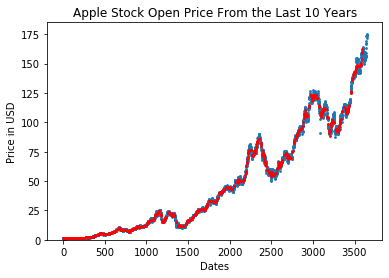

In [7]:
fig, ax = plt.subplots()
plt.scatter(numericDatesData, trimOpenPriceData, s = 3)
plt.scatter(cont_x_pred, cont_y_pred, s = 3, color = "red")
plt.title("Apple Stock Open Price From the Last 10 Years")
plt.xlabel("Dates")
plt.ylabel("Price in USD")
plt.ylim(0, max(trimOpenPriceData) + 10)
plt.show()


Like any other model, this model can be finetuned on two parameters: the polynomial and the moving window where the average is sampled.

In [8]:
#First, the diminishing nature of polynomial power can be seen through the following
SPLIT = .2           #Split Ratio of the data set 
MovingWindow = 100   #The Slices of data the model is going to regress on 
comp_index = []
for i in range(100):
    if i > 0:
        try:
            cont_x_pred, cont_y_pred, cont_x_test, cont_y_test = get_pred_poly_reg(numericDatesData, trimOpenPriceData, SPLIT, i, MovingWindow)
            mae, mse, root_mse = get_moving_average_metrics(cont_y_pred, cont_y_test)
            comp_index.append([i, mae, mse, root_mse])
        except:
            pass
index = 0
mean_absolute_error = 9999
mse = 9999
root_mse = 9999
best_index = [index, mean_absolute_error, mse, root_mse]
for model in comp_index:
    if (model[1] < best_index[1] or model[2] < best_index[2] or model[3] < best_index[3]):
        best_index = model 
print("Best Index out of", len(comp_index), "is:")
print(best_index)    

c:\users\russel\anaconda3\envs\tensorflowg\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\users\russel\anaconda3\envs\tensorflowg\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\users\russel\anaconda3\envs\tensorflowg\lib\site-packages\numpy\core\_methods.py:75: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
c:\users\russel\anaconda3\envs\tensorflowg\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\users\russel\anaconda3\envs\tensorflowg\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\users\russel\anaconda3\en

Best Index out of 86 is:
[64, 1.038700295506288, 2.7177720305757376, 1.6485666594274366]


c:\users\russel\anaconda3\envs\tensorflowg\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\users\russel\anaconda3\envs\tensorflowg\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\users\russel\anaconda3\envs\tensorflowg\lib\site-packages\numpy\core\_methods.py:75: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
c:\users\russel\anaconda3\envs\tensorflowg\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: overflow encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial)
c:\users\russel\anaconda3\envs\tensorflowg\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\users\russel\anaconda3\envs\t

In [9]:
x_power = []
MAEData = []
MSEData = []
RootMSEData = []

for model in comp_index:
    x_power.append(model[0])
    MAEData.append(model[1])
    MSEData.append(model[2])
    RootMSEData.append(model[3])  

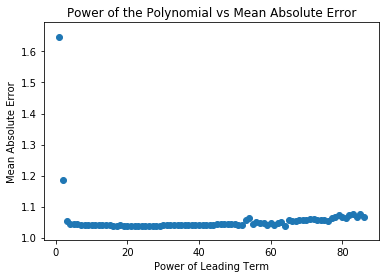

In [10]:
fig, ax = plt.subplots()
plt.scatter(x_power, MAEData)
plt.title("Power of the Polynomial vs Mean Absolute Error")
plt.xlabel("Power of Leading Term")
plt.ylabel("Mean Absolute Error")
plt.show()

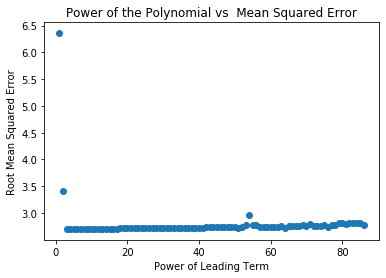

In [11]:
fig, ax = plt.subplots()
plt.scatter(x_power, MSEData)
plt.title("Power of the Polynomial vs  Mean Squared Error")
plt.xlabel("Power of Leading Term")
plt.ylabel("Root Mean Squared Error")
plt.show()

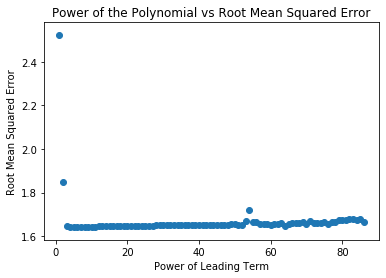

In [12]:
fig, ax = plt.subplots()
plt.scatter(x_power, RootMSEData)
plt.title("Power of the Polynomial vs Root Mean Squared Error")
plt.xlabel("Power of Leading Term")
plt.ylabel("Root Mean Squared Error")
plt.show()

Note this implies that a Moving Average maps the data very well given the model. If extracts a model at any given polynomial, it will probability gives a good prediction within the x bounds. Outside the dataset, it will fail to capture anything. From the data, the best polynomial to map the data is 64. However, the hyperparameter of moving window needs to be seen. 

In [17]:
#Hypertuning on both moving window and polynomial. 
#Let the moving window range from 1-150
#Let the polynomial be 3. Polynomial has a diminishing affect, so 3 is reasonable 
SPLIT = .2           #Split Ratio of the data set 
comp_index = []
poly = 3
for movingWindow in range(100):
    if movingWindow > 0:
        try:
            cont_x_pred, cont_y_pred, cont_x_test, cont_y_test = get_pred_poly_reg(numericDatesData, trimOpenPriceData, 
                                                                                   SPLIT, poly, movingWindow)                                
            mae, mse, root_mse = get_moving_average_metrics(cont_y_pred, cont_y_test)                                                                   
            comp_index.append([poly, movingWindow, root_mse])
        except:
            pass                                                                       
            
#The best index is the one with the lowest RMSE
best_index = []
best_index = comp_index[0]
for comp in comp_index:
    if best_index[2] > comp[2]:
        best_index = comp

print("Polynomial:" , best_index[0])
print("MovingWindow:" , best_index[1])
print("Root Mean Square Error:", best_index[2])

Polynomial: 3
MovingWindow: 14
Root Mean Square Error: 0.8475223934369204


In [22]:
movingWindows = []
RMSE = []
for comp in comp_index:
    RMSE.append(comp[2])
    movingWindows.append(comp[1])

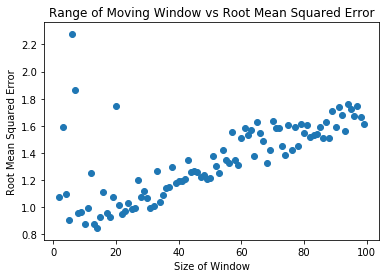

In [23]:
fig, ax = plt.subplots()
plt.scatter(movingWindows, RMSE)
plt.title("Range of Moving Window vs Root Mean Squared Error")
plt.xlabel("Size of Window")
plt.ylabel("Root Mean Squared Error")
plt.show()

As seen from above, the movingWindow has a profound effect of the RMSE on the model. It can be seen from the results above that a tight window leads to a better RMSE to a certain point.

In [24]:
#Utilizing the Prior Functions for best params
SPLIT = .2           #Split Ratio of the data set 
MovingWindow = 14   #The Slices of data the model is going to regress on 
POWER = 3           #The polynomial used to analyze the data

cont_x_pred, cont_y_pred, cont_x_test, cont_y_test = get_pred_poly_reg(numericDatesData, trimOpenPriceData, SPLIT, POWER, MovingWindow)

mae, mse, root_mse = get_moving_average_metrics(cont_y_pred, cont_y_test)
        
print("Mean Absolute Error:" , mae)
print("Mean Square Error:" , mse)
print("Root Mean Square Error:", root_mse)

Mean Absolute Error: 0.5102914577082662
Mean Square Error: 0.718294207377046
Root Mean Square Error: 0.8475223934369204


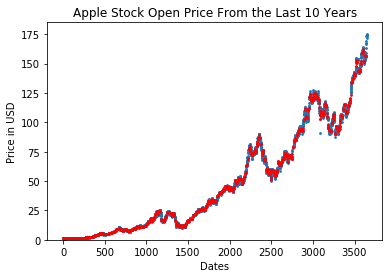

In [25]:
fig, ax = plt.subplots()
plt.scatter(numericDatesData, trimOpenPriceData, s = 3)
plt.scatter(cont_x_pred, cont_y_pred, s = 3, color = "red")
plt.title("Apple Stock Open Price From the Last 10 Years")
plt.xlabel("Dates")
plt.ylabel("Price in USD")
plt.ylim(0, max(trimOpenPriceData) + 10)
plt.show()
